Simple Robust FPOP implementation in python 

From the paper:
Changepoint Detection in the Presence of Outliers
Paul Fearnhead & Guillem Rigaill JASA 2018

Implementation ideas taken from https://github.com/kesward/FOCuS

In [1]:
import numpy as np
import portion as p
import matplotlib.pyplot as plt
from math import inf

In [2]:
class Quadratic:
    def __init__(self, a, b, c, tau, D):
        self.a = a
        self.b = b
        self.c = c
        self.tau = tau
        self.set = D
        
    def update(self, x, K, storage_list):
        xl = x - K
        xu = x + K
        # different intervals for biweight loss need different updates
        inside_quad_interval = self.set.intersection(p.open(xl, xu))
        if not inside_quad_interval.empty:
            storage_list.append(Quadratic(self.a + 1, self.b - 2*x, self.c + x**2, self.tau, inside_quad_interval))
        outside_quad_interval = self.set.difference(p.open(xl, xu))
        if not outside_quad_interval.empty:
            storage_list.append(Quadratic(self.a, self.b, self.c + K**2, self.tau, outside_quad_interval))

    # helps with plotting - need to differentiate between x array or not 
    def evaluate(self, x):
        if isinstance(x, (list, tuple, np.ndarray)):
            yvals = self.a * x**2 + self.b * x + self.c
            for i in range(len(x)):
                if x[i] not in self.set:
                    yvals[i] = None
            return yvals
        else:
            if x in self.set:
                return self.a * x**2 + self.b * x + self.c
            return None
    
    def roots(self, z):
        disc = self.b**2 - 4*self.a*(self.c-z)
        if disc < 0:
            return p.empty()
        x1 = (-self.b + np.sqrt(disc))/(2*self.a)
        x2 = (-self.b - np.sqrt(disc))/(2*self.a)
        return p.closed(min(x1,x2), max(x1,x2))
    
    def min(self):
        # check if constant func
        if self.a == 0 and self.b == 0:
            return self.c
        # check if argmin of quad within set its defined on
        elif -self.b/(2*self.a) in self.set:
            return -(self.b**2)/(4*self.a) + self.c
        # iterate through intervals that make up set and find min on each
        else:
            currmin = inf
            for ival in self.set:
                if ival.upper < -self.b/(2*self.a):
                    currmin = min(currmin, self.a*(ival.upper)**2 + self.b*ival.upper + self.c)
                else:
                    currmin = min(currmin, self.a*(ival.lower)**2 + self.b*ival.lower + self.c)
            return currmin
            
    def __repr__(self):
        return f'Quadratic: {self.a}x^2 + {self.b}x + {self.c}, tau = {self.tau}, set = {self.set}'

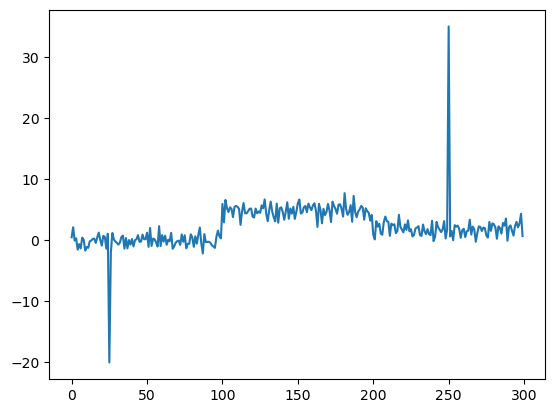

In [3]:
# sim data
X = np.concatenate((np.random.normal(size=100), np.random.normal(size=100) + 5, np.random.normal(size=100) + 2))
X[25] = -20
X[250] = 35
plt.plot(X)

In [4]:
# initialise 
n = len(X)
beta = 2*np.log(n)

# optimal values
Q = [None]*(n+1)
chpts = [None]*(n+1)
chpts[0] = 0
Q[0] = -beta
# K in biweight loss
K = 2
# range for mu
D = p.open(-inf, inf)

cost_list = [Quadratic(0,0,0,0,D)]

In [5]:
for t in range(1, n+1):
    
    # update costs with observation
    updated_cost_list = []
    for q in cost_list:
        q.update(x = X[(t-1)], K = K, storage_list=updated_cost_list)
    tau, Q[t] = min([(cost.tau, cost.min()) for cost in updated_cost_list], key = lambda t: t[1])
    chpts[t] = tau

    # compare to Q[t] + beta
    new_cost_list = []
    # Set for which constant function Q[t] + beta is better than other changes
    Qt_set = p.empty()
    for q in updated_cost_list:
        # we can prune
        if q.min() >= Q[t] + beta:
            Qt_set = Qt_set.union(q.set)
        else:
            # where Q[t] + beta line intersects with quadratic q
            line_int = q.roots(Q[t] + beta)
            Qt_set = Qt_set.union(q.set.difference(line_int))
            q.set = q.set.intersection(line_int)
            new_cost_list.append(q)
            
    new_cost_list.append(Quadratic(0, 0, Q[t] + beta, t, Qt_set))
    cost_list = new_cost_list

/tmp/ipykernel_8634/2577815180.py:37: RuntimeWarning: invalid value encountered in scalar divide
  x1 = (-self.b + np.sqrt(disc))/(2*self.a)
/tmp/ipykernel_8634/2577815180.py:38: RuntimeWarning: invalid value encountered in scalar divide
  x2 = (-self.b - np.sqrt(disc))/(2*self.a)


In [6]:
# get changepoints
CP = []
last = chpts[n]
CP.append(last)
while last > 0:
    last = chpts[last]
    CP.append(last)
CP.sort()
print(CP)

[0, 100, 200]


In [7]:
# look at quadratics at final time step
cost_list

[Quadratic: 95x^2 + -344.74053938387163x + 615.0027769904933, tau = 200, set = (1.8873595265597043,1.9306050254018632),
 Quadratic: 94x^2 + -344.8793293330679x + 618.9979613279938, tau = 200, set = [1.9306050254018632,2.0111566573875868),
 Quadratic: 93x^2 + -344.85701601829277x + 622.9978368569898, tau = 200, set = [2.0111566573875868,2.1322209136336525],
 Quadratic: 96x^2 + -336.2281112703013x + 595.9650409651567, tau = 200, set = (1.558989191335015,1.7617153715839384),
 Quadratic: 95x^2 + -329.1101328876313x + 587.2986369011172, tau = 200, set = [1.4069680271191196,1.558989191335015],
 Quadratic: 95x^2 + -336.70468052713346x + 599.9082614010174, tau = 200, set = [1.7617153715839384,1.869430098190601),
 Quadratic: 94x^2 + -336.96582033075225x + 603.8912129017589, tau = 200, set = [1.869430098190601,1.8873595265597043],
 Quadratic: 21x^2 + -88.67591802893354x + 404.1014958130901, tau = 277, set = (2.1322209136336525,2.239137391065097],
 Quadratic: 13x^2 + -62.01765036804185x + 384.980

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_8634/487203752.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$\mu$')


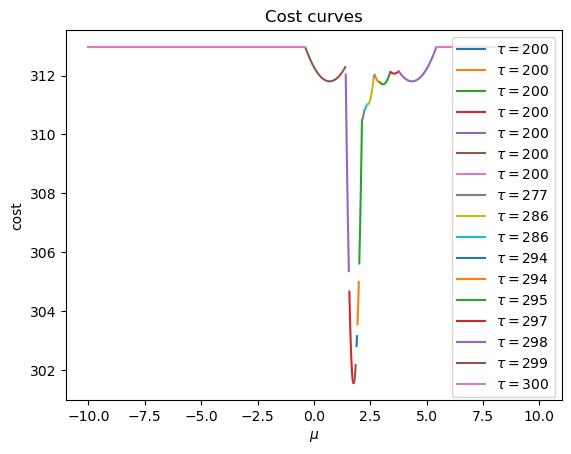

In [10]:
# plot curves
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Cost curves')

ax.set_xlabel('$\mu$')
ax.set_ylabel('cost')

mu = np.linspace(-10, 10, 1000)
for q in cost_list:
    ax.plot(mu, q.evaluate(mu), label=f'$\\tau={q.tau}$')

if cost_list:
    ax.legend()